In [2]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import pickle
import operator
import seaborn as sns
import nltk
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

% matplotlib inline

print('Python version', sys.version)
print('Pandas version', pd.__version__)
print('Numpy version', np.__version__)

Python version 3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version 0.20.3
Numpy version 1.14.0


# Import pickled text feature data

In [3]:
train_features = pd.read_pickle('../data/processed/train_text_features.pkl')

train_tar = train_features.pop('target')
train_target = np.array([int(i) for i in train_tar])

In [4]:
test_features = pd.read_pickle('../data/processed/test_text_features.pkl')

test_tar = test_features.pop('target')
test_target = np.array([int(i) for i in test_tar])

# Define Evaluation Functions

In [5]:
# Generate a confusion matrix plot
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Greys):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def find_auc(y_test, y_score):
    
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))

    plt.plot([0,1],[0,1], linestyle=":", color='grey', linewidth=4) # this is our baseline
    plt.plot(fpr, tpr, color='purple', alpha=.7, linewidth=3, label="AUC="+str(round(roc_auc, 3))) # this is our ROC curve
    
    plt.xlabel('FPR', fontsize=20)
    plt.ylabel('TPR', fontsize=20)
    plt.legend(loc=0)

    plt.show()

    print('AUC: ', roc_auc)

In [7]:
def show_most_informative_features(vectorizer, clf, n=20):
    """
    Utility function to show most informative features from sklearn
    """
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [8]:
def find_best_classifier(features, target, seed, k_folds, crossval_scoring, feature_names):

    """
    Test multiple classifiers using cross validation.
    Evaluate performance to find model with highest score as defined by the 'crossval_scoring' argument 
    ('roc_auc', 'f1', log_loss', precision', 'recall', etc)
    """

    # Test options and evaluation metric
    scoring=crossval_scoring

    # Spot Check Algorithms
    models = []
    models.append(('NaiveBayesGaussian', GaussianNB()))
    models.append(('NaiveBayesBernoulli', BernoulliNB()))
    models.append(('RandomForest', RandomForestClassifier(random_state=seed)))
    models.append(('GradientBoosting', GradientBoostingClassifier(random_state=seed)))


    # Evaluate each model in turn
    results = []
    names = []

    for name, model in models:
        kfold = StratifiedKFold(n_splits=k_folds, random_state=seed)
        cv_results = cross_val_score(model, features, target, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %s (%f), std (%f)" % (name, scoring, cv_results.mean(), cv_results.std())
        print(msg)

    zipped_eval = zip(models, [i.mean() for i in results])
    model_eval = sorted(zipped_eval, key=operator.itemgetter(1))
    
    best_clf = model_eval[-1][0][1]
    clf_name = model_eval[-1][0][0]
    print("\n Model with best {} is {}".format(scoring, clf_name))
    print('\n', best_clf)
    
    print('\n Feature Importance:')
    try:
        clf = best_clf
        clf.fit(features, target)

        feat_imp = pd.Series(clf.feature_importances_, feature_names).sort_values(ascending=False)
        feat_imp[:10].plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    except AttributeError:
        print(' Not available for {}'.format(clf_name))
        
    return best_clf

# Find Best Classifier

## Test for optimal ROC AUC Score

In [18]:
best_clf = find_best_classifier(features=train_features, 
                                target=train_target, 
                                seed=42, 
                                k_folds=5, 
                                crossval_scoring='roc_auc', 
                                feature_names=list(train_features))

NaiveBayesGaussian: roc_auc (0.755832), std (0.006269)
NaiveBayesBernoulli: roc_auc (0.854950), std (0.003463)
RandomForest: roc_auc (0.838190), std (0.006953)
GradientBoosting: roc_auc (0.814300), std (0.004583)

 Model with best roc_auc is NaiveBayesBernoulli

 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

 Feature Importance:
 Not available for NaiveBayesBernoulli


## Test for optimal Log Loss

In [20]:
best_clf = find_best_classifier(features=train_features, 
                                target=train_target, 
                                seed=42, 
                                k_folds=5, 
                                crossval_scoring='neg_log_loss', 
                                feature_names=list(train_features))

NaiveBayesGaussian: neg_log_loss (-9.481938), std (0.222841)
NaiveBayesBernoulli: neg_log_loss (-0.545044), std (0.012221)
RandomForest: neg_log_loss (-0.696332), std (0.065362)
GradientBoosting: neg_log_loss (-0.547488), std (0.000857)

 Model with best neg_log_loss is NaiveBayesBernoulli

 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

 Feature Importance:
 Not available for NaiveBayesBernoulli


## Test for optimal F1 Score

In [21]:
best_clf = find_best_classifier(features=train_features, 
                                target=train_target, 
                                seed=42, 
                                k_folds=5, 
                                crossval_scoring='f1', 
                                feature_names=list(train_features))

NaiveBayesGaussian: f1 (0.728077), std (0.004589)
NaiveBayesBernoulli: f1 (0.740615), std (0.006181)
RandomForest: f1 (0.698938), std (0.006731)
GradientBoosting: f1 (0.570992), std (0.006738)

 Model with best f1 is NaiveBayesBernoulli

 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

 Feature Importance:
 Not available for NaiveBayesBernoulli


# Visualize results of best model on test set

In [9]:
best_clf = BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [10]:
def train_score(classifier, xtrain, ytrain, xtest, ytest):
     
    # fit a model
    clf = classifier.fit(xtrain, ytrain)
    
    # score the model (accuracy)
    train_acc = clf.score(xtrain, ytrain)
    test_acc = clf.score(xtest, ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))

    # create a confusion matrix
    y_true = ytest
    y_pred = clf.predict(xtest)
    
    conf = confusion_matrix(y_true, y_pred)
    print ('\n')
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[1, 1] / (conf[0, 1] + conf[1, 1])))
    print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 0] + conf[1, 1])))

    cm = confusion_matrix(y_true, y_pred, labels=None)
    # plot the confusion matrix

    print ('\n')
    plt.figure(figsize=(6, 6))
    plot_confusion_matrix(cm)
    plt.show()
       
    print('\n')
    y_pred_prob = clf.predict_proba(xtest)
    y_prob = [pred[1] for pred in y_pred_prob]
    
    find_auc(y_test=y_true, y_score=y_prob)

Training Data Accuracy: 0.78
Test Data Accuracy:     0.76


[[2983 1072]
 [ 710 2516]]


Precision:              0.70
Recall:                 0.78




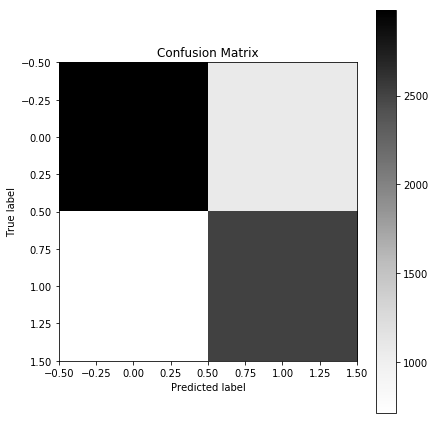

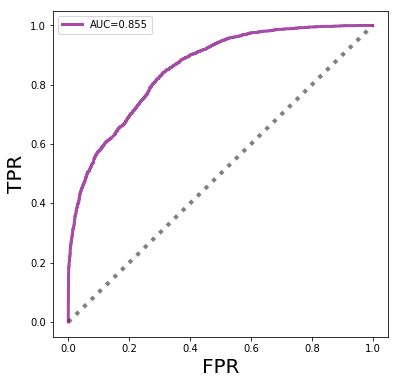

AUC:  0.8550337004440645


In [11]:
train_score(classifier=best_clf, 
            xtrain=train_features, ytrain=train_target, 
            xtest=test_features, ytest=test_target)

# Fit Training Data and Pickle Best CLF

In [40]:
model_fit = best_clf.fit(train_features, train_target)

In [41]:
with open('../models/nb_trained_text_clf.pkl', 'wb') as file:
    pickle.dump(model_fit, file)